In [ ]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [ ]:
'''
Loading the dataset
'''

dt = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [6]:
print(dt.shape)
print(test.shape)

(5000, 13)
(1206, 12)


C:\Users\uncha\AppData\Local\Temp\ipykernel_20464\1875013995.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dt.corr()


<AxesSubplot: >

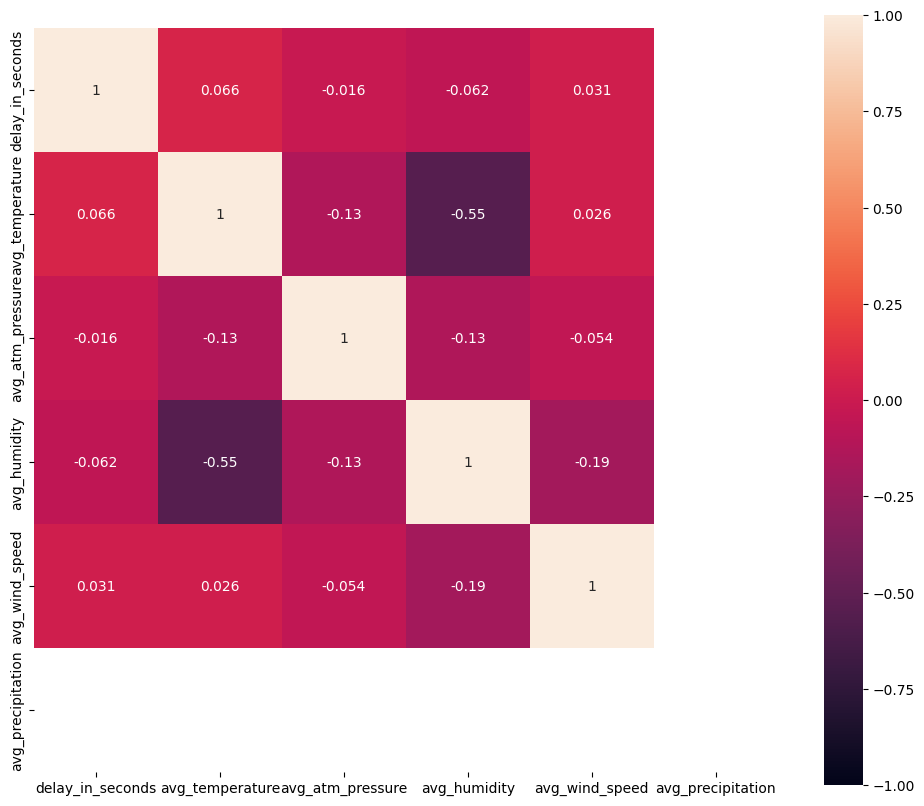

In [4]:
corr_matrix = dt.corr()
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix,vmax=1,vmin=-1,square=True,annot=True)

In [ ]:
sns.pairplot(dt)

In [5]:
dt.info()
dt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB


,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


# Feature Engineering
Since we have a lot of categorical features,we need to do feature engineering to make the models understand our dataset.

The first feature we are going to focus is the "affected_roads". This feature lists all the roads that were affected, but if we look closely we can see that most of the affected roads are repetead, and since knowing the name of the road doesn't give us much information, we are going to transform this feature to a numerical by counting the distinct number of roads that were affected.

In [7]:
test.isna().sum()

city_name              0
magnitude_of_delay     0
delay_in_seconds       0
affected_roads        22
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_precipitation      0
avg_rain               0
dtype: int64

In [ ]:
from numpy import NaN


#dt.dropna(inplace=True)
dt.replace(np.NaN,0,inplace=True)

test.replace(np.NaN,0,inplace=True)

In [ ]:
test[test['affected_roads']==0]

In [ ]:
dt.isnull().sum()

In [ ]:
def split_roads(x):
    if not isinstance(x['affected_roads'],int):
        return len(set(filter(None,x['affected_roads'].split(","))))
    else:
        return x['affected_roads']


In [ ]:
dt['affected_roads_num'] = dt.apply(split_roads,axis=1)
test['affected_roads_num'] = test.apply(split_roads,axis=1)

In [11]:
dt['avg_precipitation'].nunique()

1

In [ ]:
dt.drop('avg_precipitation', axis=1,inplace=True)
test.drop('avg_precipitation', axis=1,inplace=True)

In [ ]:
dt.drop('affected_roads',axis=1,inplace=True)
test.drop('affected_roads',axis=1,inplace=True)

The next feature we are going to focus is the city name. Let's check what are the possible city names.

In [14]:
dt['city_name'].nunique()

1

Since it only has one possible value we can drop this column because it does not add much value to our model.

In [ ]:
dt.drop('city_name',axis=1,inplace=True)
test.drop('city_name',axis=1,inplace=True)

Let's evaluate now the magnitude of delay feature.

In [ ]:
dt['magnitude_of_delay'].value_counts()

We have 3 possible values but the biggest value present is Undefined, this can cause bias to our model.


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
lb = OrdinalEncoder(categories = [['UNDEFINED','MODERATE','MAJOR']])
dt['magnitude_of_delay'] = lb.fit_transform(dt[['magnitude_of_delay']])
test['magnitude_of_delay'] = lb.fit_transform(test[['magnitude_of_delay']])


The next feature we are going to transform is the date feature.Since this is labeled as categorical, we need to transform it to the datetime format.


In [ ]:
dt['record_date'] = pd.to_datetime(dt['record_date'],format='%Y-%m-%d %H:%M')
test['record_date'] = pd.to_datetime(test['record_date'],format='%Y-%m-%d %H:%M')


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

lb_make=OrdinalEncoder(categories = [['DARK','LOW_LIGHT','LIGHT']])
dt['luminosity'] = lb_make.fit_transform(dt[['luminosity']])
test['luminosity'] = lb_make.fit_transform(test[['luminosity']])


In [ ]:
dt['avg_rain'].value_counts()

In [ ]:
avg_rain_lb = OrdinalEncoder(categories=[['Sem Chuva','chuva fraca','chuva moderada','chuva forte']])
dt['avg_rain'] = avg_rain_lb.fit_transform(dt[['avg_rain']])
test['avg_rain'] = avg_rain_lb.fit_transform(test[['avg_rain']])

In [ ]:
target = OrdinalEncoder(categories=[['None','Low','Medium','High','Very_High']])
dt['incidents'] = target.fit_transform(dt[['incidents']])


In [13]:
dt['week_day'] = dt['record_date'].dt.weekday
dt['month'] = dt['record_date'].dt.month
dt['hour'] = dt['record_date'].dt.hour
dt['day'] = dt['record_date'].dt.day


test['week_day'] = test['record_date'].dt.weekday
test['month'] = test['record_date'].dt.month
test['hour'] = test['record_date'].dt.hour
test['day'] = test['record_date'].dt.day


,magnitude_of_delay,delay_in_seconds,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,affected_roads_num
0,0.0,0,2021-03-15 23:00:00,0.0,12.0,1013.0,70.0,1.0,0.0,3,0
1,0.0,385,2021-12-25 18:00:00,0.0,12.0,1007.0,91.0,1.0,0.0,3,1
2,0.0,69,2021-03-12 15:00:00,2.0,14.0,1025.0,64.0,0.0,0.0,1,0
3,2.0,2297,2021-09-29 09:00:00,2.0,15.0,1028.0,75.0,1.0,0.0,4,3
4,0.0,0,2021-06-13 11:00:00,2.0,27.0,1020.0,52.0,1.0,0.0,0,1


In [ ]:
dt.drop('record_date',axis=1,inplace=True)
test.drop('record_date',axis=1,inplace=True)

In [ ]:
X_train = dt.drop(['incidents'],axis=1)
y_train = dt['incidents'].to_frame()

## DecisionTreeClassifier (Inicial)

In [40]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=2022)
model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=2022)

In [41]:
predicts = model.predict(test)

In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model,X_train,y_train,cv=10,scoring='accuracy')
print(scores.mean())

0.9046


## SVC


In [58]:
from sklearn.svm import SVC
model = SVC(random_state=2022,probability=False)

In [59]:
params_grid = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel' : ['rbf']}

In [60]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
svm_model = GridSearchCV(model,params_grid,cv=5,n_jobs=-1,refit=True,verbose=3)


In [61]:
svm_model.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=SVC(random_state=2022), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [62]:
svm_model.best_score_

0.8146000000000001

## Random Forest

In [63]:
param_grid = { 
    'n_estimators': [1600,1610],
    'max_features': ['sqrt'],
    'max_depth' : range(15,18),
    'criterion' :['entropy'],
    "min_samples_split": [2,3],
    "min_samples_leaf": [1,2],
    "class_weight": ["balanced_subsample"]
}

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

random_model = RandomForestClassifier(random_state=4000)

randomForest = GridSearchCV(random_model, param_grid = param_grid, n_jobs = -1, cv = 10,verbose=3, scoring='accuracy')
randomForest.fit(X_train,y_train.values.ravel())

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=4000),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['entropy'], 'max_depth': range(15, 18),
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [1600, 1610]},
             scoring='accuracy', verbose=3)

In [66]:
randomForest.best_score_
randomForest.best_params_


0.9224

In [ ]:
from sklearn.ensemble import RandomForestClassifier
bestModel = RandomForestClassifier(random_state=4000,class_weight='balanced_subsample', criterion='entropy',max_depth=15,min_samples_leaf=1,min_samples_split=2,n_estimators=1610,max_features='sqrt')
bestModel.fit(X_train,y_train.values.ravel())

In [ ]:
predicts = bestModel.predict(test)
test['incidents'] = predicts

## Decision Tree Classifier

In [73]:
from sklearn.model_selection import GridSearchCV, ParameterGrid


#mean_absolute_error(y_test, predictions)
#mean_squared_error(y_test,predictions)
param_dict={
    "criterion":['gini','entropy'],
    "min_samples_split":range(1,3),
    "min_samples_leaf":range(1,3)
}
gs = GridSearchCV(model, param_grid = param_dict,n_jobs=-1,cv=10,scoring='accuracy',verbose=1)
gs.fit(X_train,y_train)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


c:\Users\uncha\Documents\Masters\DAA\DAA\env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\uncha\Documents\Masters\DAA\DAA\env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\uncha\Documents\Masters\DAA\DAA\env\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\uncha\Documents\Masters\DAA\DAA\env\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dis

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2022),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': range(1, 3),
                         'min_samples_split': range(1, 3)},
             scoring='accuracy', verbose=1)

In [74]:
gs.best_params_
gs.best_estimator_
gs.best_score_

0.9206000000000001

In [ ]:
best_model=DecisionTreeClassifier(random_state=2022,criterion='entropy',max_depth=13,min_samples_leaf=3,min_samples_split=8)
best_model.fit(X_train,y_train)

In [ ]:
predicts = best_model.predict(test)
test['incidents'] = predicts

In [ ]:
dt.info()

## XGBoost


In [ ]:
param_grid = { 
    'n_estimators': [100,120],
    'learning_rate': [0.2,0.25],
    'gamma': [0],
    'subsample':[0.5,1],
    'min_child_weight': [0,1,2],
    'booster' :['gbtree'],
}

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xg_model = XGBClassifier(random_state=4000)

xg = GridSearchCV(xg_model, param_grid = param_grid, n_jobs = -1, cv = 10,verbose=3, scoring='accuracy')
xg.fit(X_train,y_train.values.ravel())


In [ ]:
xg.best_score_
xg.best_params_


In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
bestModel = XGBClassifier(random_state=4000,booster= 'gbtree',gamma= 0,learning_rate=0.25,min_child_weight= 1,n_estimators=100,subsample=1)
bestModel.fit(X_train,y_train.values.ravel())

In [ ]:
predicts = bestModel.predict(test)
test['incidents'] = predicts

# MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.preprocessing import MinMaxScaler




In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


In [ ]:
scaler_X = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y_train)
X_scaled = pd.DataFrame(scaler_X.transform(X_train[X_train.columns]),columns=X_train.columns)
#Y_scaled = pd.DataFrame(scaler_y.transform(y_train[y_train.columns]),columns=y_train.columns)
scaler_test = MinMaxScaler(feature_range=(0,1)).fit(test)
test_scaled = pd.DataFrame(scaler_test.transform(test[test.columns]),columns=test.columns)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_train, test_size=0.25, random_state=2022)

In [ ]:
def build_model(activation = 'relu', learning_rate = 0.01):
    model = Sequential()
    model.add(Dense(12, input_dim=12,activation = activation))
    model.add(Dense(20, activation = activation))
    model.add(Dense(5, activation = 'softmax'))
    
    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer = tf.optimizers.SGD(learning_rate),
        metrics = ['accuracy','sparse_categorical_accuracy']
    )
    return model

In [ ]:
tuning_dict = {
    'activation' : ['relu','identity','logistic', 'tanh'],
    'learning_rate' : [1,0.1,0.01,0.001]
}

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
model = KerasClassifier(build_fn=build_model, epochs = 200, batch_size=64)
grid_search = GridSearchCV(estimator = model,
                           param_grid= tuning_dict,
                           cv = kf,
                           scoring='accuracy',
                           refit = True,
                           verbose = 1,n_jobs=-1)
grid_search.fit(X_scaled, y_train,validation_split=0.25)

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
best_model.fit(X_scaled,y_train,epochs=20)

In [ ]:
from livelossplot import PlotLossesKerasTF

best_model.fit(X_scaled,y_train,validation_split=0.40,epochs=100,callbacks=[PlotLossesKerasTF()],verbose=1)


In [ ]:
predictions = best_model.predict(test_scaled)


In [ ]:
print(predictions)

In [ ]:
y_test_unscaled = pd.DataFrame(scaler_test.inverse_transform(test_scaled))

In [ ]:
y_test_unscaled['incidents'] = predictions

In [ ]:
print(y_test_unscaled)

In [ ]:
test = y_test_unscaled

# Building the output file


In [ ]:
test['incidents'] =  target.inverse_transform(test[['incidents']])

In [ ]:
test.info()

In [ ]:
test.head()

In [ ]:
test.index +=1
test.reset_index(drop=False,inplace=True)

final_csv = test.to_csv(r'finalt.csv',header=["RowId","Incidents"],columns=['index','incidents'],index=False)

In [ ]:
test.tail()